In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import scipy.optimize
from scipy import stats
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import griddata
import yfinance as yf

In [2]:
#downoad SP500
start_date = "2014-01-01"
end_date = "2022-01-01"
ticker_name = '^GSPC'
stock_data = yf.download(ticker_name, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


Preparation

In [3]:
price = stock_data['Adj Close'].values
vol = stock_data['Volume'].values
days = price.shape[0]
print(days)
ret = (price[1:]-price[:-1])/price[0:-1]

zeta = -3
R = 0.01
R_daily = R/250
N = 1000
T = 100
n_win = math.floor((days-N-2)/T)

2015


The annualized mean return is 0.12654139233105985
The annualized std of return is 0.3062248472719275
The annualized sharpe ratio is 0.38057457900394065


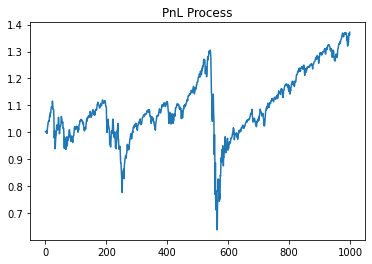

In [72]:
# Question 1A

alpha_star = []
bt_date0 = N
vect_means = []
vect_sig = []
for k in range(n_win):
    data_cali = ret[(bt_date0-N):bt_date0]
    vect_means.append(np.mean(data_cali))
    vect_sig.append(np.var(data_cali)**0.5)
    vect_returns_add = np.array([R_daily,np.mean(data_cali)+np.var(data_cali)**0.5])
    vect_returns_sub = np.array([R_daily,np.mean(data_cali)-np.var(data_cali)**0.5])

    obj = lambda alpha : 0.5*((1+alpha@vect_returns_add)**zeta+(1+alpha@vect_returns_sub)**zeta)
    alpha0 = np.array([0.5,0.5])
    constr = {'type': 'eq', 'fun': lambda alpha: np.sum(alpha)-1}
    opt = scipy.optimize.minimize(obj, alpha0, tol=1e-20, constraints=constr,  options={'maxiter':1e6})
    alpha_star.append(opt.x)
    bt_date0 = bt_date0+T

#print(alpha_star)

# back testing
PnL = []
daily_ret4 = []
cum_ret = 1
bt_date0 = N
for k in range(n_win):
    a = alpha_star[k]
    for r in ret[bt_date0:(bt_date0+T)]:
        cum_ret = cum_ret*(1+a@np.array([R_daily,r]))
        PnL.append(cum_ret)
        daily_ret4.append(a@np.array([R_daily,r]))
    bt_date0 = bt_date0 + T

#print(PnL)
plt.plot(PnL)
plt.title('PnL Process')

print('The annualized mean return is', np.mean(daily_ret4)*250)
print('The annualized std of return is', np.std(daily_ret4)*np.sqrt(250))
print('The annualized sharpe ratio is', (np.mean(daily_ret4)-R_daily)*np.sqrt(250)/np.std(daily_ret4))

The annualized mean return is 0.12654142334562044
The annualized std of return is 0.30622533975760163
The annualized sharpe ratio is 0.38057406822659084


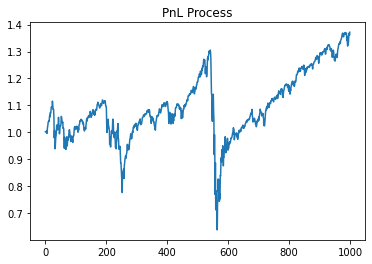

In [69]:
# Question 1A: CHECK (obj with one variable): OK

# alpha_star = []
# bt_date0 = N
# vect_means = []
# for k in range(n_win):
#     data_cali = ret[(bt_date0-N):bt_date0]
#     vect_means.append(np.mean(data_cali))
#     mu = np.mean(data_cali)
#     sig = np.var(data_cali)**0.5
#
#
#     obj = lambda alpha : 0.5*((1+R_daily+alpha*(mu+sig-R_daily))**zeta+(1+R_daily+alpha*(mu-sig-R_daily))**zeta)
#     alpha0 = 0.5
#     opt = scipy.optimize.minimize(obj, alpha0, tol=1e-20, options={'maxiter':1e6})
#     alpha_star.append(opt.x)
#     bt_date0 = bt_date0+T
#
# #print(alpha_star)
#
# # back testing
# PnL = []
# daily_ret4 = []
# cum_ret = 1
# bt_date0 = N
# for k in range(n_win):
#     a = alpha_star[k]
#     for r in ret[bt_date0:(bt_date0+T)]:
#         cum_ret = cum_ret*(1+R_daily+a*(r-R_daily))
#         PnL.append(cum_ret)
#         daily_ret4.append(R_daily+a*(r-R_daily))
#     bt_date0 = bt_date0 + T
#
# #print(PnL)
# plt.plot(PnL)
# plt.title('PnL Process')
#
# print('The annualized mean return is', np.mean(daily_ret4)*250)
# print('The annualized std of return is', np.std(daily_ret4)*np.sqrt(250))
# print('The annualized sharpe ratio is', (np.mean(daily_ret4)-R_daily)*np.sqrt(250)/np.std(daily_ret4))

The annualized mean return with transaction cost lambda=0.02 is 0.07897649165994755
The annualized std of return with transaction cost lambda=0.02 is 0.3076794761679235
The annualized sharpe ratio with transaction cost lambda=0.02 is 0.22418294687391482


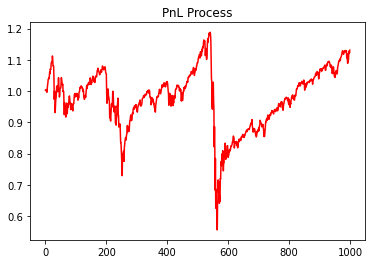

In [85]:
# Question 1B

#alpha_star = np.array(alpha_star)
#print(alpha_star)
l_cost = 0.02
# back testing
PnL_costs = []
daily_ret4_costs = []
cum_ret_costs = 1
bt_date0 = N
for k in range(n_win):
    a = alpha_star[k]
    for r in ret[bt_date0:(bt_date0+T)]:
        #A_i = np.abs(a[1]-((a[1]*(1+r))/(1+a@np.array([R_daily,r]))))+np.abs(a[0]-((a[0]*(1+R_daily))/(1+a@np.array([R_daily,r])))) #if T-cost also applied to risk-less asset
        A_i = np.abs(a[1]-((a[1]*(1+r))/(1+a@np.array([R_daily,r])))) # if T-cost only on risky asset
        cum_ret_costs = cum_ret_costs*(1+a@np.array([R_daily,r])-l_cost*A_i)
        PnL_costs.append(cum_ret_costs)
        daily_ret4_costs.append(a@np.array([R_daily,r])-l_cost*A_i)
    bt_date0 = bt_date0 + T

#print(PnL)
plt.plot(PnL_costs,'r')
plt.title('PnL Process')

print('The annualized mean return with transaction cost lambda=0.02 is', np.mean(daily_ret4_costs)*250)
print('The annualized std of return with transaction cost lambda=0.02 is', np.std(daily_ret4_costs)*np.sqrt(250))
print('The annualized sharpe ratio with transaction cost lambda=0.02 is', (np.mean(daily_ret4_costs)-R_daily)*np.sqrt(250)/np.std(daily_ret4_costs))

0
[0.9895333993484475, 0.9882686839527506, 0.9875709031143585, 0.9880572716933911, 0.9892163167633323, 0.9859612907566301, 0.9911688067584692, 0.9951818579423719, 0.9976951858151134, 1.0020965215601163, 1.0031130652696365, 1.0039136817464038, 1.0031970339279719, 1.0076258297552365, 1.011896237329197, 1.0096450599799582, 1.0156159316668445, 1.014585654654751, 1.017379604796052, 1.0225352909716046, 1.0239253133359283, 1.0235580980474293, 1.0239463052374393, 1.031557528512793, 1.027184311344577, 1.020169558404483, 1.0204840316300874, 1.0200827042357907, 1.0065701910437983, 0.9809879172707745, 0.9913535836241378, 0.9877142421806907, 0.9646465917282091, 0.9734828294522561, 0.9819026400788041, 0.983517581618277, 0.9917631533235195, 0.9992858820459501, 0.9995178870783348, 0.9958181568209932, 0.9924098146897743, 0.9930270927701498, 1.0029795154263508, 1.0103998237502057, 1.0023162305620084, 0.9953492398766933, 0.9870720780990021, 0.9902009126019791, 0.9970240314163532, 0.9986854711914294, 0.99

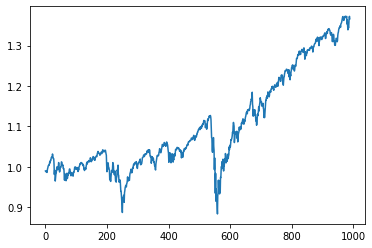

In [36]:
# Question 1C : It takes approximately 3/4 minutes per iteration so 30/35 minutes in total

# # Creating a grid for a
grid_a = np.linspace(-1.0,2.5, num=100) # grid with 100 points

# # Needed for back testing
PnL_cost_c = []             # final PnL process
daily_ret4_cost_c = []      # PnL-1
cum_ret_cost_c = 1          # cumulative returns
bt_date0 = N
alpha_track_matrices = []   # just to fill the first row of alpha matrix (but I do not use this row after so not relevant
A_value_temp = 0            # value of Ai: derived after thanks to the interpolation on each row of alpha_matrix
for u in range(n_win):
    print(u)
    data_cali = ret[(bt_date0-N):bt_date0]
    mu = np.mean(data_cali)
    sig = np.var(data_cali)**0.5

    # Start DPP on trading window
    v_matrix = np.zeros(shape=(T+1,len(grid_a)))            # matrix containing the v(t,a) values
    alpha_matrix = np.zeros(shape=(T+1,len(grid_a)))        # matrix containing alpha* values
    if (u!=0):
        alpha_matrix[0,:] = alpha_track_matrices[u-1][-1]

    v_matrix[T:,:] = 1/zeta                                 # DPP initial condition: v(T,a)=1/zeta
    for i in range (T,1,-1):
        for j in range(len(grid_a)):
            spl_v_matrix = InterpolatedUnivariateSpline(grid_a, v_matrix[i,:],ext=3)  # interpolation realized on each row--> get a function of v(t,a)

            obj2 = lambda alpha : -0.5*(spl_v_matrix(alpha*(1+mu+sig)/(1+R_daily+alpha*(mu+sig-R_daily)))*((1+R_daily+alpha*(mu+sig-R_daily)-l_cost*abs(alpha-grid_a[j]))**zeta)+spl_v_matrix(alpha*(1+mu-sig)/(1+R_daily+alpha*(mu-sig-R_daily)))*((1+R_daily+alpha*(mu-sig-R_daily)-l_cost*abs(alpha-grid_a[j]))**zeta))

            x0 = 0.5
            opt2 = scipy.optimize.minimize(obj2, x0, tol=1e-20, options={'maxiter':1e6})
            alpha_matrix[i-1,j] = opt2.x[0]         # filling the matrix alpha

            v_matrix[i-1,j] = 0.5*(spl_v_matrix(alpha_matrix[i-1,j]*(1+mu+sig)/(1+R_daily+alpha_matrix[i-1,j]*(mu+sig-R_daily)))*((1+R_daily+alpha_matrix[i-1,j]*(mu+sig-R_daily)-l_cost*abs(alpha_matrix[i-1,j]-grid_a[j]))**zeta)+spl_v_matrix(alpha_matrix[i-1,j]*(1+mu-sig)/(1+R_daily+alpha_matrix[i-1,j]*(mu-sig-R_daily)))*((1+R_daily+alpha_matrix[i-1,j]*(mu-sig-R_daily)-l_cost*abs(alpha_matrix[i-1,j]-grid_a[j]))**zeta)) # filling the matrix V

    alpha_track_matrices.append(alpha_matrix)
    temp = 1 # I do not use the first row
    for r in ret[bt_date0:(bt_date0+T-1)]:
        spl_alpha = InterpolatedUnivariateSpline(grid_a, alpha_matrix[temp,:],ext=3)   # interpolation realized on each row of the alpha matrix

        a_cost = [1-spl_alpha(A_value_temp),spl_alpha(A_value_temp)]   # alpha* values needed
        cum_ret_cost_c = cum_ret_cost_c*(1+a_cost@np.array([R_daily,r])-l_cost*abs(a_cost[1]-A_value_temp))
        PnL_cost_c.append(cum_ret_cost_c)
        daily_ret4_cost_c.append(a_cost@np.array([R_daily,r])-l_cost*abs(a_cost[1]-A_value_temp))

        A_value = spl_alpha(A_value_temp)*(1+r)/(1+spl_alpha(A_value_temp)*r)    # we change the value of Ai thanks to spl_alpha(A_value_temp) obtained
        A_value_temp = A_value
        temp = temp+1
    print(PnL_cost_c)
    bt_date0 = bt_date0+T

plt.plot(PnL_cost_c)
print('The annualized mean return with transaction cost lambda=0.02 is', np.mean(daily_ret4_cost_c)*250)
print('The annualized std of return with transaction cost lambda=0.02 is', np.std(daily_ret4_cost_c)*np.sqrt(250))
print('The annualized sharpe ratio with transaction cost lambda=0.02 is', (np.mean(daily_ret4_cost_c)-R_daily)*np.sqrt(250)/np.std(daily_ret4_cost_c))

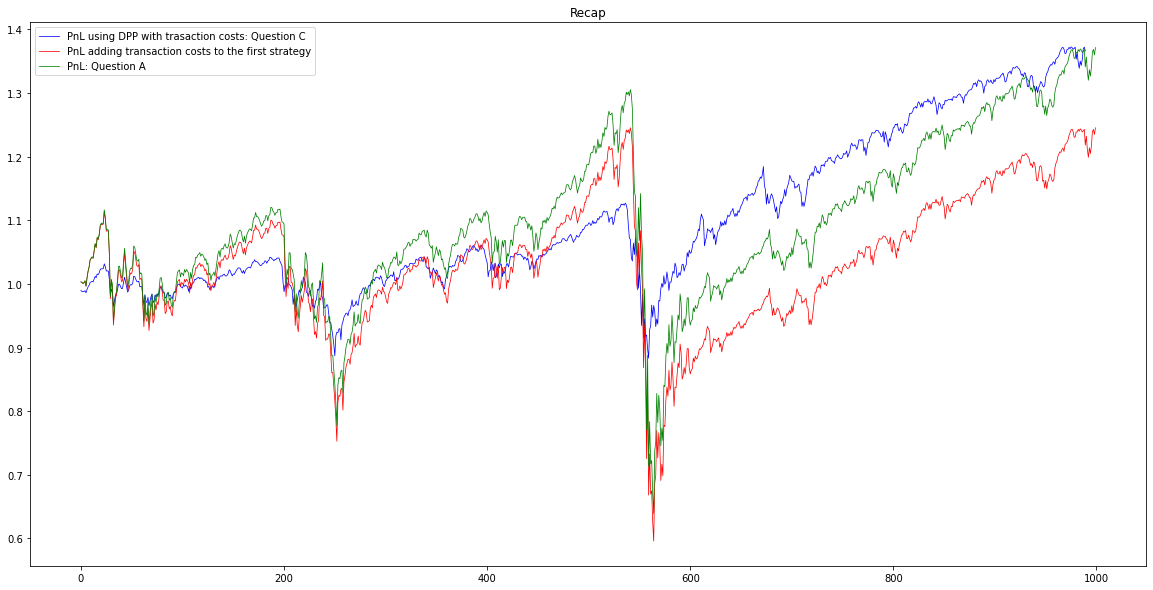

In [84]:
fig = plt.figure(1, figsize=(20, 10))
plt.plot(PnL_cost_c,'b',linewidth=0.75,label='PnL using DPP with trasaction costs: Question C')
plt.plot(PnL_costs,'r',linewidth=0.75,label='PnL adding transaction costs to the first strategy')
plt.plot(PnL,'g',linewidth=0.75,label='PnL: Question A')
plt.legend(loc="upper left")
plt.title('Recap')
plt.show()